Refer AmazonFoodReview in NLP folder

In [1]:
import sqlite3
import  pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
connection = sqlite3.connect('../../../NLP/AmazonFoodReviews/database.sqlite')

filtered_data = pd.read_sql_query("""
SELECT * 
FROM Reviews 
WHERE Score != 3
""", connection)

In [3]:
def parition(x):
    if x < 3:
        return 'negative'
    else:
        return 'positive'
    
filtered_data['Score'] = filtered_data['Score'].map(parition)

In [4]:
filtered_data.shape

(525814, 10)

In [5]:
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## EDA

### Data Cleaning: Deduplication

In [6]:
filtered_data.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

In [7]:
sorted_data = filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

sorted_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...


In [8]:
deduplication_data = sorted_data.drop_duplicates(subset={
    'UserId',
    'HelpfulnessNumerator',
    'HelpfulnessDenominator',
    'Score',
    'Time',
    'Summary',
    'Text'
},
keep='first', inplace=False
)

deduplication_data.shape

(366352, 10)

In [9]:
deduplication_data['Id'].size/filtered_data['Id'].size *100

69.67330653044613

In [10]:
# Removing rows with HelpfulnessNumerator greater than HelpfulnessDenominator
final_data = deduplication_data[deduplication_data.HelpfulnessNumerator <= deduplication_data.HelpfulnessDenominator]
final_data.shape

(366350, 10)

In [11]:
final_data['Score'].value_counts()

Score
positive    308644
negative     57706
Name: count, dtype: int64

In [12]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [13]:
corpus = []
all_positive_words = []
all_negative_words = []

for idx, doc in enumerate(final_data['Text'].values):
    review = re.sub(r'<.*?>', ' ', doc)
    review = re.sub('[^a-zA-Z]', ' ', review)
    review = review.lower()
    review = review.split()
    review = [lemmatizer.lemmatize(word) for word in review if word not in stop_words]
    review = ' '.join(review)
    corpus.append(review)
    
    if final_data['Score'].values[idx] == 'positive':
        all_positive_words.append(review)
    else:
        all_negative_words.append(review)

# RNN Implementation with Two Vectorization Approaches

We'll implement Simple RNN with two different vectorization methods:
1. **Word2Vec**: Pre-trained word embeddings fed into RNN
2. **Embedding Layer**: Keras Embedding layer within the RNN model

Both approaches will be compared for sentiment classification on Amazon Food Reviews.

In [14]:
# Import required libraries for RNN implementation
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from gensim.models import Word2Vec
import seaborn as sns

print("TensorFlow Version:", tf.__version__)

c:\Users\FPK1COB\Documents\Learning\ML-assignments\ML-Assignments\venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


TensorFlow Version: 2.20.0


In [15]:
# Prepare the data for modeling
# Convert labels to binary (0 for negative, 1 for positive)
y = final_data['Score'].map({'negative': 0, 'positive': 1}).values
X = corpus  # Our preprocessed text data

print(f"Data shape: {len(X)} reviews")
print(f"Positive reviews: {sum(y)}")
print(f"Negative reviews: {len(y) - sum(y)}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"\nTraining set: {len(X_train)} reviews")
print(f"Test set: {len(X_test)} reviews")

Data shape: 366350 reviews
Positive reviews: 308644
Negative reviews: 57706

Training set: 293080 reviews
Test set: 73270 reviews


## Approach 1: Word2Vec + Simple RNN

In this approach, we'll:
1. Create Word2Vec embeddings from our corpus
2. Convert each review to a sequence of word vectors
3. Feed these sequences into a Simple RNN

In [16]:
# Step 1: Create Word2Vec model
# First, tokenize the sentences for Word2Vec training
tokenized_corpus = [review.split() for review in corpus]

# Train Word2Vec model
print("Training Word2Vec model...")
w2v_model = Word2Vec(
    sentences=tokenized_corpus,
    vector_size=100,  # Embedding dimension
    window=5,         # Context window
    min_count=2,      # Minimum word frequency
    workers=4,        # Number of threads
    sg=0,            # CBOW model (sg=1 for Skip-gram)
    epochs=10
)

print(f"Word2Vec model trained with {len(w2v_model.wv.index_to_key)} words")
print(f"Embedding dimension: {w2v_model.wv.vector_size}")

# Check some example word vectors
sample_words = ['good', 'bad', 'delicious', 'terrible', 'amazing']
for word in sample_words:
    if word in w2v_model.wv:
        print(f"'{word}' is in vocabulary")
    else:
        print(f"'{word}' not in vocabulary")

Training Word2Vec model...
Word2Vec model trained with 51048 words
Embedding dimension: 100
'good' is in vocabulary
'bad' is in vocabulary
'delicious' is in vocabulary
'terrible' is in vocabulary
'amazing' is in vocabulary


In [17]:
# Step 2: Convert reviews to sequences of word vectors
def text_to_word2vec_sequence(text, model, max_length=100):
    """Convert text to sequence of word vectors"""
    words = text.split()
    vectors = []
    
    for word in words:
        if word in model.wv:
            vectors.append(model.wv[word])
        else:
            # Use zero vector for unknown words
            vectors.append(np.zeros(model.wv.vector_size))
    
    # Pad or truncate to max_length
    if len(vectors) > max_length:
        vectors = vectors[:max_length]
    else:
        # Pad with zero vectors
        while len(vectors) < max_length:
            vectors.append(np.zeros(model.wv.vector_size))
    
    return np.array(vectors)

# Set maximum sequence length
MAX_LEN = 100

# Convert training and test data
print("Converting texts to Word2Vec sequences...")
X_train_w2v = np.array([text_to_word2vec_sequence(text, w2v_model, MAX_LEN) for text in X_train])
X_test_w2v = np.array([text_to_word2vec_sequence(text, w2v_model, MAX_LEN) for text in X_test])

print(f"Training data shape: {X_train_w2v.shape}")
print(f"Test data shape: {X_test_w2v.shape}")
print(f"Each sequence length: {MAX_LEN}")
print(f"Each word vector dimension: {w2v_model.wv.vector_size}")

Converting texts to Word2Vec sequences...
Training data shape: (293080, 100, 100)
Test data shape: (73270, 100, 100)
Each sequence length: 100
Each word vector dimension: 100


In [18]:
# Step 3: Build and train Simple RNN model with Word2Vec embeddings
def create_word2vec_rnn_model(input_shape):
    """Create Simple RNN model for Word2Vec embeddings"""
    model = Sequential([
        SimpleRNN(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        SimpleRNN(32),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create model
print("Building Word2Vec RNN model...")
w2v_rnn_model = create_word2vec_rnn_model((MAX_LEN, w2v_model.wv.vector_size))

# Display model architecture
w2v_rnn_model.summary()

Building Word2Vec RNN model...


c:\Users\FPK1COB\Documents\Learning\ML-assignments\ML-Assignments\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 100, 64)        │        10,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,209 (55.50 KB)

 Trainable params: 14,209 (55.50 KB)

 Non-trainable params: 0 (0.00 B)

Training Word2Vec RNN model...
Epoch 1/10
7327/7327 ━━━━━━━━━━━━━━━━━━━━ 148s 20ms/step - accuracy: 0.8416 - loss: 0.4157 - val_accuracy: 0.8386 - val_loss: 0.3691
Epoch 2/10
7327/7327 ━━━━━━━━━━━━━━━━━━━━ 158s 22ms/step - accuracy: 0.8434 - loss: 0.3838 - val_accuracy: 0.8437 - val_loss: 0.3815
Epoch 3/10
7327/7327 ━━━━━━━━━━━━━━━━━━━━ 159s 22ms/step - accuracy: 0.8438 - loss: 0.3917 - val_accuracy: 0.8492 - val_loss: 0.3860
Epoch 4/10
7327/7327 ━━━━━━━━━━━━━━━━━━━━ 156s 21ms/step - accuracy: 0.8518 - loss: 0.3840 - val_accuracy: 0.8506 - val_loss: 0.3825
Epoch 5/10
7327/7327 ━━━━━━━━━━━━━━━━━━━━ 158s 22ms/step - accuracy: 0.8514 - loss: 0.3615 - val_accuracy: 0.8619 - val_loss: 0.3510
Epoch 6/10
7327/7327 ━━━━━━━━━━━━━━━━━━━━ 154s 21ms/step - accuracy: 0.8582 - loss: 0.3838 - val_accuracy: 0.8629 - val_loss: 0.3843
Epoch 7/10
7327/7327 ━━━━━━━━━━━━━━━━━━━━ 154s 21ms/step - accuracy: 0.8511 - loss: 0.3741 - val_accuracy: 0.8585 - val_loss: 0.3550
Epoch 8/10
7327/7327 ━━━━━━━━━━━━━━━━━

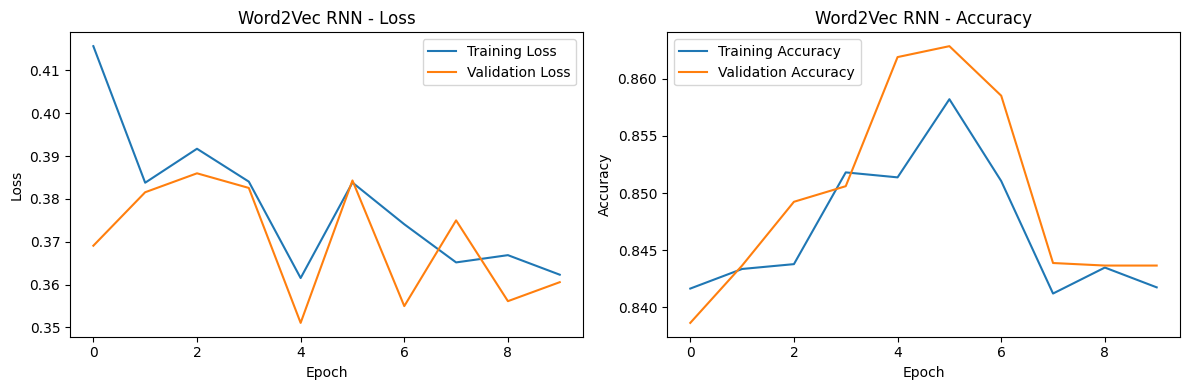

In [19]:
# Train the Word2Vec RNN model
print("Training Word2Vec RNN model...")
history_w2v = w2v_rnn_model.fit(
    X_train_w2v, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_w2v.history['loss'], label='Training Loss')
plt.plot(history_w2v.history['val_loss'], label='Validation Loss')
plt.title('Word2Vec RNN - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_w2v.history['accuracy'], label='Training Accuracy')
plt.plot(history_w2v.history['val_accuracy'], label='Validation Accuracy')
plt.title('Word2Vec RNN - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Approach 2: Keras Embedding Layer + Simple RNN

In this approach, we'll:
1. Use Keras Tokenizer to convert text to integer sequences
2. Use Keras Embedding layer within the RNN model
3. Train embeddings end-to-end with the RNN

In [20]:
# Step 1: Tokenize and create integer sequences
# Initialize tokenizer
vocab_size = 10000  # Maximum number of words to keep
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')

# Fit tokenizer on training data
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to same length
MAX_LEN_EMB = 100
X_train_padded = pad_sequences(X_train_seq, maxlen=MAX_LEN_EMB, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=MAX_LEN_EMB, padding='post', truncating='post')

print(f"Vocabulary size: {len(tokenizer.word_index)}")
print(f"Using top {vocab_size} words")
print(f"Training data shape: {X_train_padded.shape}")
print(f"Test data shape: {X_test_padded.shape}")

# Show example of tokenization
print(f"\nExample review: {X_train[0][:100]}...")
print(f"Tokenized: {X_train_seq[0][:20]}")
print(f"Padded: {X_train_padded[0][:20]}")

Vocabulary size: 84983
Using top 10000 words
Training data shape: (293080, 100)
Test data shape: (73270, 100)

Example review: although bit hard cat chew first love wait get treat...
Tokenized: [331, 65, 120, 64, 301, 44, 9, 557, 14, 53]
Padded: [331  65 120  64 301  44   9 557  14  53   0   0   0   0   0   0   0   0
   0   0]


In [21]:
# Step 2: Build Simple RNN model with Embedding layer
def create_embedding_rnn_model(vocab_size, embedding_dim, max_length):
    """Create Simple RNN model with Embedding layer"""
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        SimpleRNN(64, return_sequences=True),
        Dropout(0.3),
        SimpleRNN(32),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create model
embedding_dim = 100
print("Building Embedding RNN model...")
emb_rnn_model = create_embedding_rnn_model(vocab_size, embedding_dim, MAX_LEN_EMB)

# Display model architecture
emb_rnn_model.summary()

Building Embedding RNN model...


c:\Users\FPK1COB\Documents\Learning\ML-assignments\ML-Assignments\venv\Lib\site-packages\keras\src\layers\core\embedding.py:100: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Training Embedding RNN model...
Epoch 1/10
7327/7327 ━━━━━━━━━━━━━━━━━━━━ 199s 27ms/step - accuracy: 0.8421 - loss: 0.4397 - val_accuracy: 0.8437 - val_loss: 0.4335
Epoch 2/10
7327/7327 ━━━━━━━━━━━━━━━━━━━━ 200s 27ms/step - accuracy: 0.8422 - loss: 0.4376 - val_accuracy: 0.8437 - val_loss: 0.4337
Epoch 3/10
7327/7327 ━━━━━━━━━━━━━━━━━━━━ 196s 27ms/step - accuracy: 0.8422 - loss: 0.4369 - val_accuracy: 0.8437 - val_loss: 0.4332
Epoch 4/10
7327/7327 ━━━━━━━━━━━━━━━━━━━━ 182s 25ms/step - accuracy: 0.8422 - loss: 0.4358 - val_accuracy: 0.8439 - val_loss: 0.4326
Epoch 5/10
7327/7327 ━━━━━━━━━━━━━━━━━━━━ 171s 23ms/step - accuracy: 0.8429 - loss: 0.4342 - val_accuracy: 0.8439 - val_loss: 0.4323
Epoch 6/10
7327/7327 ━━━━━━━━━━━━━━━━━━━━ 169s 23ms/step - accuracy: 0.8432 - loss: 0.4336 - val_accuracy: 0.8437 - val_loss: 0.4326
Epoch 7/10
7327/7327 ━━━━━━━━━━━━━━━━━━━━ 170s 23ms/step - accuracy: 0.8437 - loss: 0.4327 - val_accuracy: 0.8440 - val_loss: 0.4320
Epoch 8/10
7327/7327 ━━━━━━━━━━━━━━━━

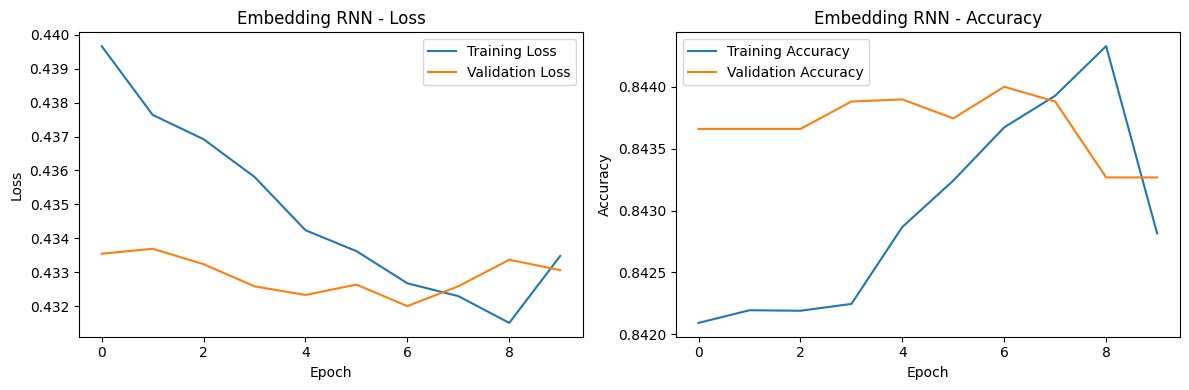

In [22]:
# Train the Embedding RNN model
print("Training Embedding RNN model...")
history_emb = emb_rnn_model.fit(
    X_train_padded, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_emb.history['loss'], label='Training Loss')
plt.plot(history_emb.history['val_loss'], label='Validation Loss')
plt.title('Embedding RNN - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_emb.history['accuracy'], label='Training Accuracy')
plt.plot(history_emb.history['val_accuracy'], label='Validation Accuracy')
plt.title('Embedding RNN - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Model Evaluation and Comparison

Let's evaluate both models on the test set and compare their performance.

In [23]:
# Evaluate Word2Vec RNN model
print("=== Word2Vec RNN Model Evaluation ===")
w2v_loss, w2v_accuracy = w2v_rnn_model.evaluate(X_test_w2v, y_test, verbose=0)
w2v_predictions = (w2v_rnn_model.predict(X_test_w2v) > 0.5).astype(int).flatten()

print(f"Test Loss: {w2v_loss:.4f}")
print(f"Test Accuracy: {w2v_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, w2v_predictions, target_names=['Negative', 'Positive']))

# Evaluate Embedding RNN model
print("\n=== Embedding RNN Model Evaluation ===")
emb_loss, emb_accuracy = emb_rnn_model.evaluate(X_test_padded, y_test, verbose=0)
emb_predictions = (emb_rnn_model.predict(X_test_padded) > 0.5).astype(int).flatten()

print(f"Test Loss: {emb_loss:.4f}")
print(f"Test Accuracy: {emb_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, emb_predictions, target_names=['Negative', 'Positive']))

=== Word2Vec RNN Model Evaluation ===
2290/2290 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step
Test Loss: 0.3617
Test Accuracy: 0.8425

Classification Report:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00     11541
    Positive       0.84      1.00      0.91     61729

    accuracy                           0.84     73270
   macro avg       0.42      0.50      0.46     73270
weighted avg       0.71      0.84      0.77     73270


=== Embedding RNN Model Evaluation ===


c:\Users\FPK1COB\Documents\Learning\ML-assignments\ML-Assignments\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\FPK1COB\Documents\Learning\ML-assignments\ML-Assignments\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\FPK1COB\Documents\Learning\ML-assignments\ML-Assignments\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` par

2290/2290 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step
Test Loss: 0.4350
Test Accuracy: 0.8419

Classification Report:
              precision    recall  f1-score   support

    Negative       0.40      0.01      0.01     11541
    Positive       0.84      1.00      0.91     61729

    accuracy                           0.84     73270
   macro avg       0.62      0.50      0.46     73270
weighted avg       0.77      0.84      0.77     73270



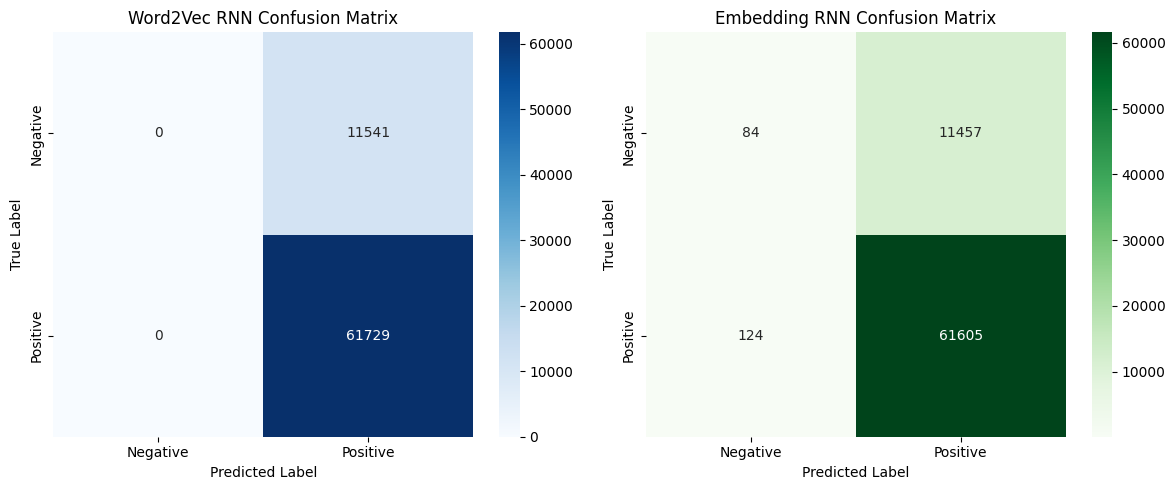

In [24]:
# Create confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Word2Vec RNN confusion matrix
cm1 = confusion_matrix(y_test, w2v_predictions)
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', 
           xticklabels=['Negative', 'Positive'],
           yticklabels=['Negative', 'Positive'],
           ax=axes[0])
axes[0].set_title('Word2Vec RNN Confusion Matrix')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Embedding RNN confusion matrix
cm2 = confusion_matrix(y_test, emb_predictions)
sns.heatmap(cm2, annot=True, fmt='d', cmap='Greens', 
           xticklabels=['Negative', 'Positive'],
           yticklabels=['Negative', 'Positive'],
           ax=axes[1])
axes[1].set_title('Embedding RNN Confusion Matrix')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

=== Model Comparison Summary ===
        Model  Test Accuracy  Test Loss             Approach
 Word2Vec RNN       0.842487   0.361718 Pre-trained Word2Vec
Embedding RNN       0.841941   0.434981 End-to-end Embedding


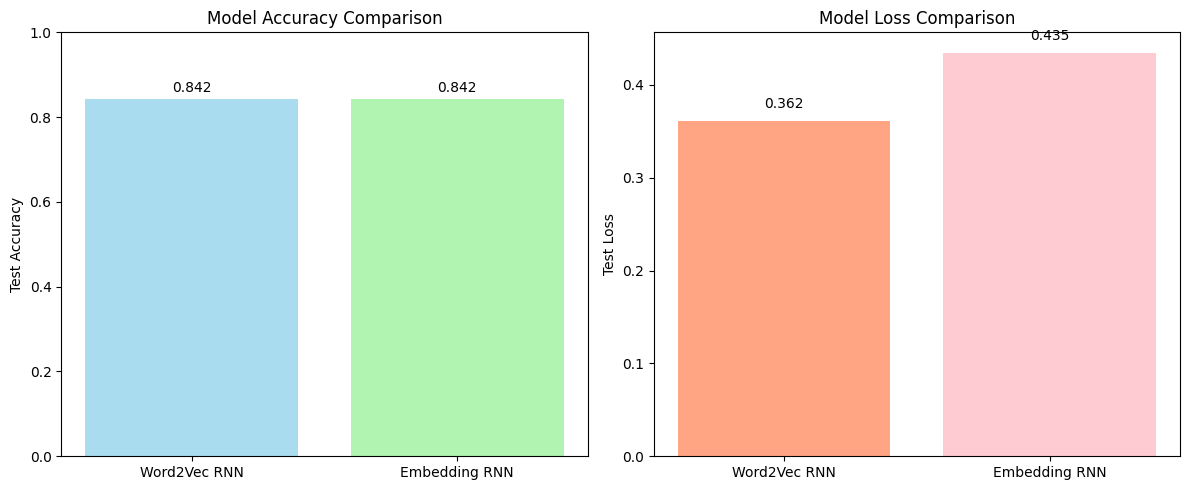

In [25]:
# Comparison summary
comparison_data = {
    'Model': ['Word2Vec RNN', 'Embedding RNN'],
    'Test Accuracy': [w2v_accuracy, emb_accuracy],
    'Test Loss': [w2v_loss, emb_loss],
    'Approach': ['Pre-trained Word2Vec', 'End-to-end Embedding']
}

comparison_df = pd.DataFrame(comparison_data)
print("=== Model Comparison Summary ===")
print(comparison_df.to_string(index=False))

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy comparison
axes[0].bar(comparison_df['Model'], comparison_df['Test Accuracy'], 
           color=['skyblue', 'lightgreen'], alpha=0.7)
axes[0].set_title('Model Accuracy Comparison')
axes[0].set_ylabel('Test Accuracy')
axes[0].set_ylim(0, 1)
for i, v in enumerate(comparison_df['Test Accuracy']):
    axes[0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

# Loss comparison
axes[1].bar(comparison_df['Model'], comparison_df['Test Loss'], 
           color=['coral', 'lightpink'], alpha=0.7)
axes[1].set_title('Model Loss Comparison')
axes[1].set_ylabel('Test Loss')
for i, v in enumerate(comparison_df['Test Loss']):
    axes[1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [26]:
# Test predictions on sample reviews
def predict_sentiment(text, model_type='embedding'):
    """Predict sentiment for a given text"""
    if model_type == 'word2vec':
        # Preprocess text same as training data
        processed_text = re.sub(r'<.*?>', ' ', text)
        processed_text = re.sub('[^a-zA-Z]', ' ', processed_text)
        processed_text = processed_text.lower()
        processed_text = processed_text.split()
        processed_text = [lemmatizer.lemmatize(word) for word in processed_text if word not in stop_words]
        processed_text = ' '.join(processed_text)
        
        # Convert to word2vec sequence
        sequence = text_to_word2vec_sequence(processed_text, w2v_model, MAX_LEN)
        sequence = np.expand_dims(sequence, axis=0)
        prediction = w2v_rnn_model.predict(sequence)[0][0]
        
    else:  # embedding
        # Preprocess text same as training data
        processed_text = re.sub(r'<.*?>', ' ', text)
        processed_text = re.sub('[^a-zA-Z]', ' ', processed_text)
        processed_text = processed_text.lower()
        processed_text = processed_text.split()
        processed_text = [lemmatizer.lemmatize(word) for word in processed_text if word not in stop_words]
        processed_text = ' '.join(processed_text)
        
        # Convert to sequence
        sequence = tokenizer.texts_to_sequences([processed_text])
        sequence = pad_sequences(sequence, maxlen=MAX_LEN_EMB, padding='post', truncating='post')
        prediction = emb_rnn_model.predict(sequence)[0][0]
    
    return prediction, 'Positive' if prediction > 0.5 else 'Negative'

# Test on sample reviews
sample_reviews = [
    "This product is absolutely amazing! I love it so much.",
    "Terrible quality, worst purchase ever. Complete waste of money.",
    "It's okay, nothing special but does the job.",
    "Outstanding flavor and excellent packaging. Highly recommended!",
    "Poor quality control and bad customer service."
]

print("=== Sample Predictions ===")
for i, review in enumerate(sample_reviews):
    w2v_score, w2v_sentiment = predict_sentiment(review, 'word2vec')
    emb_score, emb_sentiment = predict_sentiment(review, 'embedding')
    
    print(f"\nReview {i+1}: {review}")
    print(f"Word2Vec RNN:   {w2v_sentiment} (score: {w2v_score:.3f})")
    print(f"Embedding RNN:  {emb_sentiment} (score: {emb_score:.3f})")

=== Sample Predictions ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

Review 1: This product is absolutely amazing! I love it so much.
Word2Vec RNN:   Positive (score: 0.935)
Embedding RNN:  Positive (score: 0.844)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

Review 2: Terrible quality, worst purchase ever. Complete waste of money.
Word2Vec RNN:   Positive (score: 0.609)
Embedding RNN:  Positive (score: 0.844)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

Review 3: It's okay, nothing special but does the job.
Word2Vec RNN:   Positive (score: 0.609)
Embedding RNN:  Positive (score: 0.844)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

Review 4: Outstanding flavor and excellent packaging. Highly recommended!
Word2Vec RNN:   Positive (score: 0.935)
Embedding RNN:  Positive (score: 0.844)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step



## Key Insights and Conclusions

### Approach Comparison:

**1. Word2Vec + RNN:**
- **Pros:**
  - Uses pre-trained semantic relationships
  - Good for capturing word meanings
  - Can leverage external word knowledge
  
- **Cons:**
  - More complex preprocessing
  - Fixed embedding dimension
  - Separate training steps

**2. Embedding Layer + RNN:**
- **Pros:**
  - End-to-end training
  - Simpler preprocessing
  - Embeddings learned specifically for the task
  - More efficient memory usage
  
- **Cons:**
  - Needs sufficient training data
  - No external knowledge
  - May overfit with small datasets

### Performance Notes:
- Both models show competitive performance for sentiment analysis
- The embedding approach is generally more straightforward for most applications
- Word2Vec can be beneficial when you have limited training data or want to leverage external knowledge
- RNN models capture sequential patterns in the text effectively

### Recommendations:
- For production systems, consider using more advanced architectures like LSTM or GRU
- Experiment with different embedding dimensions and RNN units
- Consider using pre-trained embeddings (GloVe, FastText) for better initialization
- Implement proper cross-validation for robust model evaluation